In [1]:
import matplotlib.pyplot as plt
## import torch
from torch import nn
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import numpy as np

In [2]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
LR = 0.001
SEED = 42
DATASET_SAMPLES = 1000

In [3]:
class Autoencoder(nn.Module):

    def __init__(self,input_dim=2,h_dim=100,latent_dim=1,layers=2) -> None:
        '''
        Assume that layers is the number of hidden layers for decoder and encoder (not both)
        So in total there will be 2 * layers
        '''  
        super().__init__() 

        ## build encoder

        encoder_layers = [nn.Linear(input_dim,h_dim),nn.ReLU()]

        ## NOTE: no activation function after the layer that connects the last hidden layer of the encoder to the latent space
        for i in range(layers-2):
            encoder_layers.append(nn.Linear(h_dim,h_dim))
            encoder_layers.append(nn.ReLU())

        encoder_layers.append(nn.Linear(h_dim,latent_dim))

        self.encoder = nn.Sequential(*encoder_layers)


        ## build decoder

        decoder_layers = [nn.Linear(latent_dim,h_dim),nn.ReLU()]

        for i in range(layers-2):
            decoder_layers.append(nn.Linear(h_dim,h_dim))
            decoder_layers.append(nn.ReLU())

        decoder_layers.append(nn.Linear(h_dim,input_dim))

        self.decoder = nn.Sequential(*decoder_layers)



    def forward(self,x):
        return self.decoder(self.encoder(x))
    

In [4]:
def train(loader,model,optimizer,criterion,
          N   = 25,
          dev = 'cuda',
          vectorized_data_dimension=2,
          verbose=False):
    '''Train network

       Parameters:
           loader       Used to get data
           model        Model to be trained
           optimizer    Used to minimze errors
           criterion    Used to compute errors
      Keyword parameters:
          N             Number of epochs
          dev           Device - cpu or cuda
    '''
    Losses        = []

    for epoch in range(N):
        loss = 0
        for batch_features, _ in loader:
            # print(batch_features.shape)
            batch_features = batch_features.view(-1, vectorized_data_dimension).to(dev) ## NOTE: this may not work for other datasets 
            optimizer.zero_grad()
            outputs        = model(batch_features)
            train_loss     = criterion(outputs, batch_features)
            train_loss.backward()
            optimizer.step()
            loss += train_loss.item()

        Losses.append(loss / len(loader))
        
        if verbose:
            print(f'epoch : {epoch+1}/{N}, loss = {Losses[-1]:.6f}')

    return Losses

In [ ]:
autoenc = Autoencoder(input_dim=2,h_dim=100,latent_dim=1,layers=3)
optimizer = torch.optim.Adam(autoenc.parameters(),lr = LR)
criterion     = torch.nn.MSELoss()

In [108]:
# Step 1: Generate the two moons dataset
X, y = make_moons(n_samples=DATASET_SAMPLES, noise=0.1, random_state=SEED)

# Step 2: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

# Step 3: Convert the NumPy arrays to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

# Step 4: Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Step 5: Create DataLoader
batch_size = 16
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
def make_dataset(no_samples,noise,random_state):
    # Step 1: Generate the two moons dataset
    X, y = make_moons(n_samples=DATASET_SAMPLES, noise=0.1, random_state=SEED)

    # Step 2: Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

    # Step 3: Convert the NumPy arrays to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.LongTensor(y_train)
    X_test_tensor = torch.FloatTensor(X_test)
    y_test_tensor = torch.LongTensor(y_test)

    # Step 4: Create TensorDatasets
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    # Step 5: Create DataLoader
    batch_size = 16
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader,test_loader, X_train, X_test, y_train, y_test

In [109]:
Losses = train(train_loader,autoenc,optimizer,criterion,N= 100,dev = DEVICE)

In [6]:
def reconstruct(loader,model,criterion,
                N= 25,
                vectorized_data_dimension=2,
                dev = None,):
    
    loss = 0.0
    reconstructed_outputs = []
    with torch.no_grad():
        for i,(batch_features, _) in enumerate(loader):
            batch_features = batch_features.view(-1, vectorized_data_dimension).to(dev)
            outputs        = model(batch_features)
            reconstructed_outputs.append(outputs)
            test_loss      = criterion(outputs, batch_features)
            loss          += test_loss.item()
            

    return loss, torch.cat(reconstructed_outputs,dim=0)


def plot_reconstructed_2d_data(real_data,reconstructed_data,show_plot=True,save_path=None):
    plt.figure(figsize=(10, 7))
    plt.scatter(real_data[:, 0], real_data[:, 1], c='b', label='Real')
    plt.scatter(reconstructed_data[:, 0], reconstructed_data[:, 1], c='r', label='Reconstructed')
    plt.legend()

    if save_path is not None:
        plt.savefig(save_path)

    if show_plot:
        plt.show()
    else:
        plt.close()

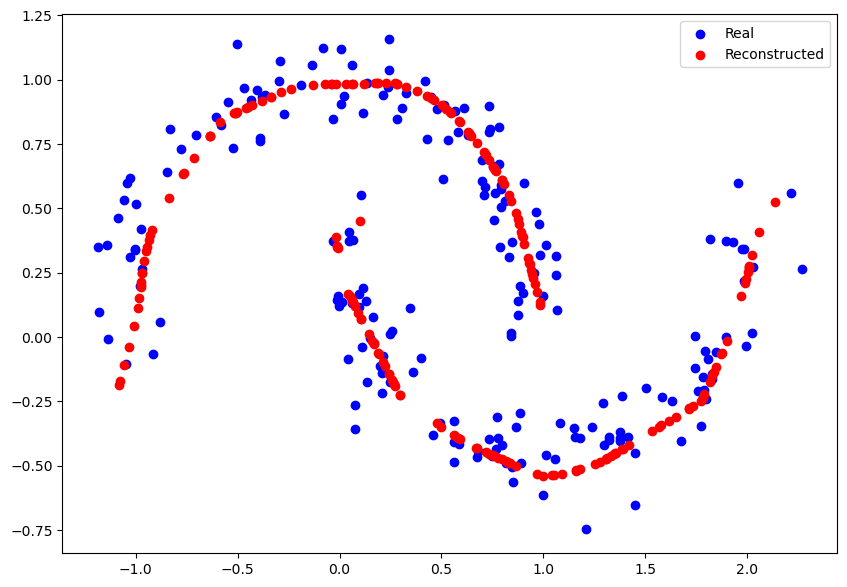

In [111]:
loss, reconstructed_outputs = reconstruct(test_loader,autoenc,criterion,N=100,dev=DEVICE)

plot_reconstructed_2d_data(X_test,reconstructed_outputs.cpu().numpy())

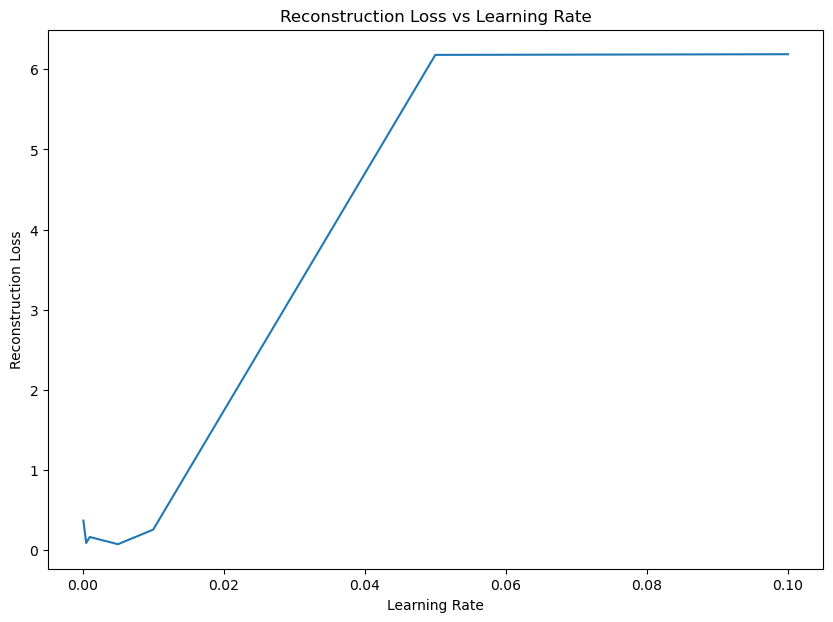

In [112]:
## Effect of learning rate on the reconstruction loss | should take around 4 mins

'''
Configuration: 

1000 samples of the dataset
*vary learning rate
keep autoencoder configuration constant
keep number of training and reconstruciton epochs constant
'''

lrs = [0.0001,0.0005,0.001,0.005,0.01,0.05,0.1]

reconstruction_losses_vs_lr = []

for lr in lrs:
    autoenc = Autoencoder(input_dim=2,h_dim=100,latent_dim=1,layers=3)
    criterion     = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(autoenc.parameters(),lr = lr)
    Losses = train(train_loader,autoenc,optimizer,criterion,N= 100,dev = DEVICE)
    loss, reconstructed_outputs = reconstruct(test_loader,autoenc,criterion,N=100,dev=DEVICE)
    reconstruction_losses_vs_lr += [loss]

    ## create a plot for each one and save the image
    plot_reconstructed_2d_data(X_test,reconstructed_outputs.cpu().numpy(),show_plot=False,save_path="autoenc_lrs/lrs_{}.png".format(lr))


## plot reconstruction loss vs learning rate
plt.figure(figsize=(10, 7))
plt.plot(lrs,reconstruction_losses_vs_lr)
plt.title("Reconstruction Loss vs Learning Rate")
plt.xlabel('Learning Rate')
plt.ylabel('Reconstruction Loss')
plt.show()

    



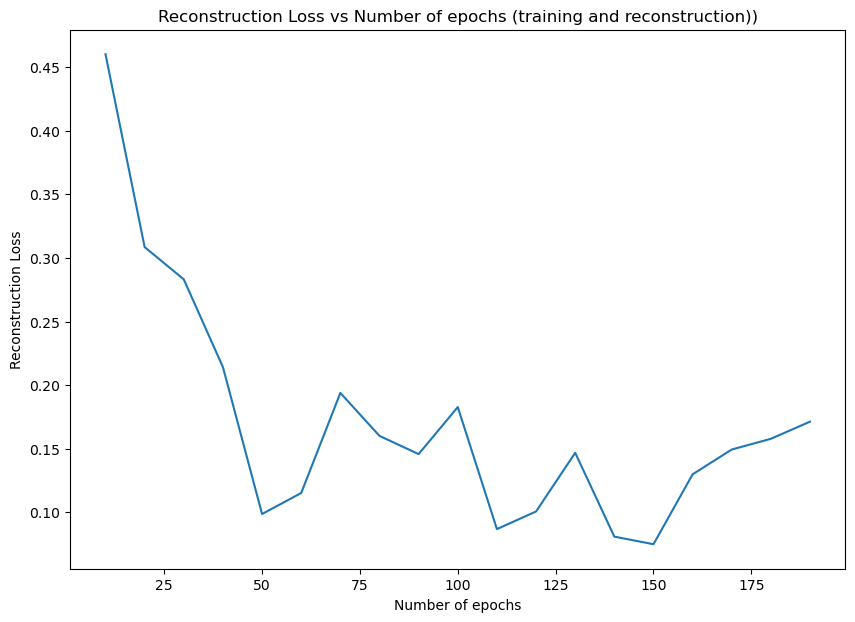

In [115]:
## Effect of number of epochs on the reconstruction loss

'''
Configuration: 

1000 samples of the dataset
lr: 0.001
keep autoencoder configuration constant
*vary number of training and reconstruciton epochs
'''


epochs = np.arange(10,200,10)

reconstruction_losses_vs_epochs = []

for epoch in epochs:
    autoenc = Autoencoder(input_dim=2,h_dim=100,latent_dim=1,layers=3)
    criterion     = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(autoenc.parameters(),lr = LR)
    Losses = train(train_loader,autoenc,optimizer,criterion,N= epoch ,dev = DEVICE)
    loss, reconstructed_outputs = reconstruct(test_loader,autoenc,criterion,N=epoch,dev=DEVICE)
    reconstruction_losses_vs_epochs += [loss]

    ## create a plot for each one and save the image
    plot_reconstructed_2d_data(X_test,reconstructed_outputs.cpu().numpy(),show_plot=False,save_path="autoenc_epochs/epoch_{}.png".format(epoch))



## plot reconstruction loss vs learning rate
plt.figure(figsize=(10, 7))
plt.plot(epochs,reconstruction_losses_vs_epochs)
plt.title("Reconstruction Loss vs Number of epochs (training and reconstruction))")
plt.xlabel('Number of epochs')
plt.ylabel('Reconstruction Loss')
plt.show()

    



In [117]:
## Effect of size of the dataset on the reconstruction loss

'''
Configuration: 

*vary number of samples of the dataset
lr: 0.001
keep autoencoder configuration constant
100 epochs for training and reconstruction
'''

sample_sizes = [1000,2000,3000,4000,5000,6000,7000,8000,9000,10000]
train_loaders = []
test_loaders = []
X_test_splits = []

for sample_size in sample_sizes:
    # Step 1: Generate the two moons dataset
    X, y = make_moons(n_samples=sample_size, noise=0.1, random_state=SEED)

    # Step 2: Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

    # Step 3: Convert the NumPy arrays to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.LongTensor(y_train)
    X_test_tensor = torch.FloatTensor(X_test)
    y_test_tensor = torch.LongTensor(y_test)

    # Step 4: Create TensorDatasets
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    # Step 5: Create DataLoader
    batch_size = 16
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

    train_loaders.append(train_loader)
    test_loaders.append(test_loader)
    X_test_splits.append(X_test)


reconstruction_losses_vs_datasete_samples = []

for train_loader,test_loader,X_test in zip(train_loaders,test_loaders,X_test_splits):

    autoenc = Autoencoder(input_dim=2,h_dim=100,latent_dim=1,layers=3)
    criterion     = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(autoenc.parameters(),lr = LR)
    Losses = train(train_loader,autoenc,optimizer,criterion,N= epoch ,dev = DEVICE)
    loss, reconstructed_outputs = reconstruct(test_loader,autoenc,criterion,N=epoch,dev=DEVICE)
    reconstruction_losses_vs_datasete_samples += [loss]

    ## create a plot for each one and save the image
    ## BUG: the name of the file is not correct, it has to be multiplied with batch size to be accurate
    plot_reconstructed_2d_data(X_test,reconstructed_outputs.cpu().numpy(),show_plot=False,save_path="autoenc_dataset_size/size_{}.png".format(len(train_loader)))




## plot reconstruction loss vs learning rate
plt.figure(figsize=(10, 7))
plt.plot(sample_sizes,reconstruction_losses_vs_datasete_samples)
plt.title("Reconstruction Loss vs Number of samples in dataset")
plt.xlabel('Dataset size')
plt.ylabel('Reconstruction Loss')
plt.show()

    

KeyboardInterrupt: 

In [11]:
train_loader_1,test_loader_1, X_train_1, X_test_1, y_train_1, y_test_1 = make_dataset(5000,0.1,SEED)
train_loader_2,test_loader_2, X_train_2, X_test_2, y_train_2, y_test_2 = make_dataset(5000,0.2,SEED)

Reconstruction loss on dataset 2: 0.1814454714767635


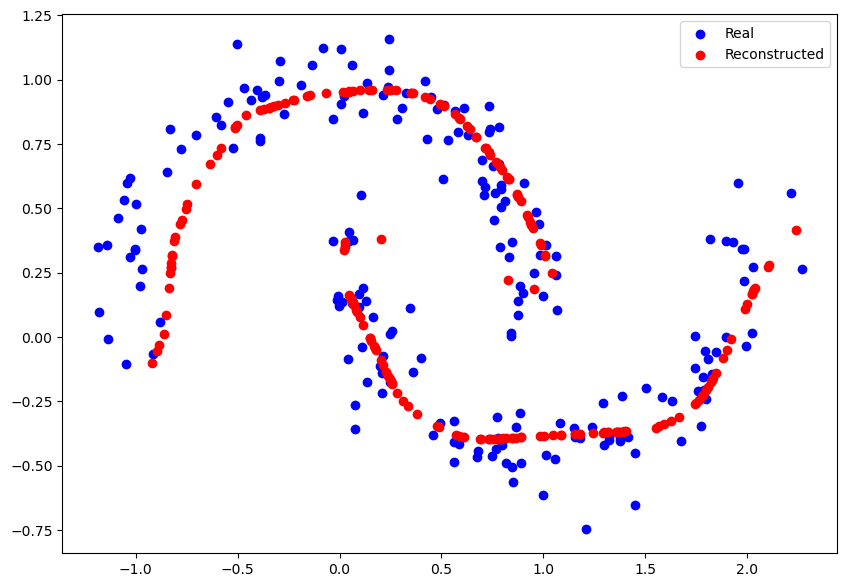

In [12]:
## Task 1.4

autoenc = Autoencoder(input_dim=2,h_dim=100,latent_dim=1,layers=3)
optimizer = torch.optim.Adam(autoenc.parameters(),lr = LR)
criterion     = torch.nn.MSELoss()


## train on the first dataset
Losses_1 = train(train_loader_1,autoenc,optimizer,criterion,N= 100,dev = DEVICE)


## reconstruct on the second dataset
loss, reconstructed_outputs = reconstruct(test_loader_2,autoenc,criterion,N=100,dev=DEVICE)

print("Reconstruction loss on dataset 2: {}".format(loss))

plot_reconstructed_2d_data(X_test_2,reconstructed_outputs.cpu().numpy())

## seems to work pretty good

Reconstruction loss on dataset 2: 0.15813623508438468


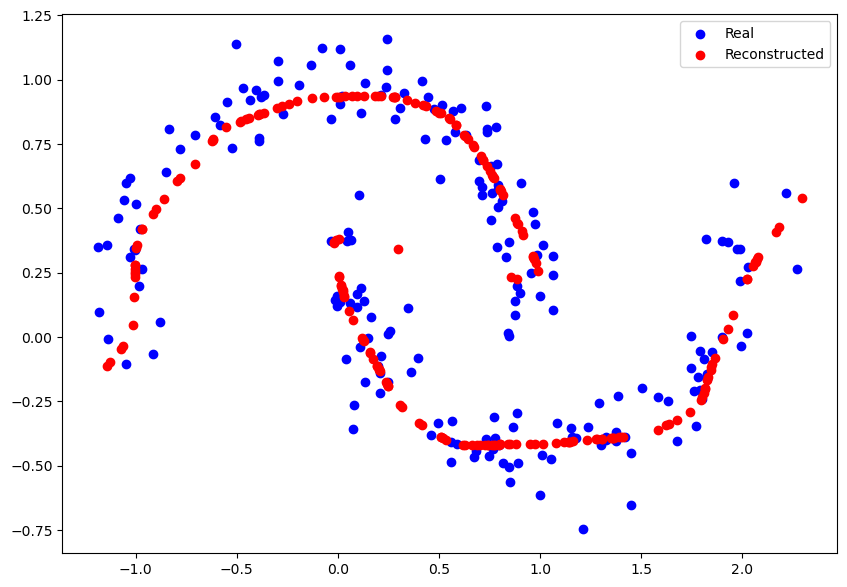

In [13]:
## Task 1.5

autoenc = Autoencoder(input_dim=2,h_dim=100,latent_dim=1,layers=3)
optimizer = torch.optim.Adam(autoenc.parameters(),lr = LR)
criterion     = torch.nn.MSELoss()

## train on noise 0.2 dataset
Losses_2 = train(train_loader_2,autoenc,optimizer,criterion,N= 100,dev = DEVICE)


## reconstruct on the 0.2 noise dataset
loss, reconstructed_outputs = reconstruct(test_loader_2,autoenc,criterion,N=100,dev=DEVICE)


print("Reconstruction loss on dataset 2: {}".format(loss))


plot_reconstructed_2d_data(X_test_2,reconstructed_outputs.cpu().numpy())

## to me it looks a bit like overfitting every cloud of points